# requirements:
```
pandas
mecab-python3
scikit-learn
matplotlib
nlplt
```

In [11]:
import pandas as pd
import MeCab
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib import rcParams
import nlplot

In [12]:
def mecab_sep(text,stopwords=['ため','とも']):
	m = MeCab.Tagger()
	node = m.parseToNode(text)
	words_list = []
	while node:
		if node.feature.split(",")[0] in ["名詞"] and node.surface not in stopwords:
			words_list.append(node.surface)
		node = node.next
	return words_list

### Bag-of-words / tf-idf
def calc_vecs(docs):
	vectorizer = TfidfVectorizer(analyzer=mecab_sep)
	vecs = vectorizer.fit_transform(docs)
	return vecs.toarray()

In [14]:
df = pd.read_csv("datasets/jk_rs_themes.csv",encoding='UTF-8')
tatget_labs = [
    '朝廣研','安部研','石田研','合志研','下川研',
    '成研','田中研','仲研','米元研','アプドゥハン研',
    '稲永研','于研','石田俊研','澤田研','安武研','前田研']

target_docs_df = df[df["研究室"].isin(tatget_labs )] 
target_docs_df.head()

年度 学科／研究科  研究室     学籍番号    賞    氏名   要旨  \
3   H17  情報科学科   成研  02JK005  NaN  足達祐治  NaN   
6   H17  情報科学科   仲研  02JK008  NaN   安部剛  NaN   
7   H17  情報科学科  澤田研  02JK009  NaN  阿部信孝  NaN   
10  H17  情報科学科  稲永研  02JK013  NaN  伊賀哲郎  NaN   
11  H17  情報科学科  合志研  02JK014  NaN  池田憲司  NaN   

                                      題目  
3                  対面教育を支援するためのウェブ助言システム  
6                       生化学反応シミュレータの比較評価  
7   FPGAを搭載したロボット教材のためのIPとしてKUE-CHIP2の検討  
10              空港における目的地への交通手段検索システムの開発  
11              人の反応・判断能力測定用ドライビングシミュレータ

In [15]:
target_docs = target_docs_df["題目"].tolist()
all_docs_vecs = calc_vecs(target_docs_df["題目"])
n_clust = 10
# 参考：KMeans　k-means法によるクラスタリング
#  https://sabopy.com/py/scikit-learn-11/
vec = KMeans(n_clusters=n_clust, init="k-means++",n_init="auto")
vec.fit(all_docs_vecs)
m = len(vec.labels_)
vec.labels_[:10]

array([7, 6, 4, 8, 9, 6, 0, 6, 8, 6], dtype=int32)

In [17]:
# target_docs_df["クラス"] = vec.labels_
target_docs_df.loc[:,['クラスタ']] = vec.labels_
pd.crosstab(target_docs_df["研究室"],target_docs_df["クラスタ"])
cross_survive= pd.crosstab(target_docs_df['クラスタ'], target_docs_df['研究室'],normalize='index')
target_docs_df.head()

年度 学科／研究科  研究室     学籍番号    賞    氏名   要旨  \
3   H17  情報科学科   成研  02JK005  NaN  足達祐治  NaN   
6   H17  情報科学科   仲研  02JK008  NaN   安部剛  NaN   
7   H17  情報科学科  澤田研  02JK009  NaN  阿部信孝  NaN   
10  H17  情報科学科  稲永研  02JK013  NaN  伊賀哲郎  NaN   
11  H17  情報科学科  合志研  02JK014  NaN  池田憲司  NaN   

                                      題目  クラスタ  
3                  対面教育を支援するためのウェブ助言システム     7  
6                       生化学反応シミュレータの比較評価     6  
7   FPGAを搭載したロボット教材のためのIPとしてKUE-CHIP2の検討     4  
10              空港における目的地への交通手段検索システムの開発     8  
11              人の反応・判断能力測定用ドライビングシミュレータ     9

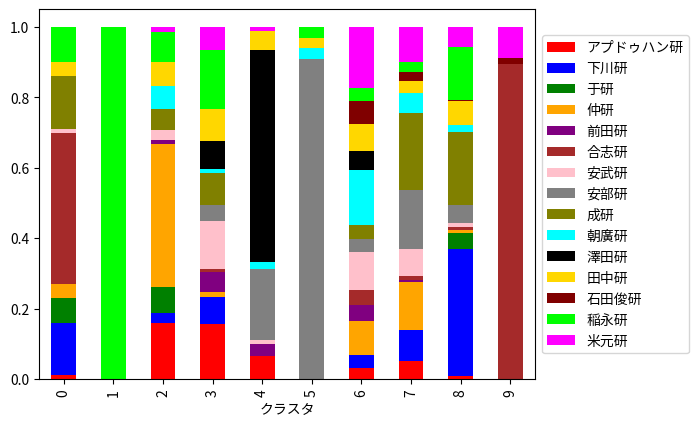

In [18]:
#文字化け
# plt.rcParams["font.family"] = "MS Gothic"
plt.rcParams["font.family"] = "Noto Sans CJK JP"
# plt.figure(figsize=[15,20])
#カラー
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", 
        ["red", "blue", "green","orange", "purple", "brown", "pink", "gray", "olive", "cyan", 
         "black", "gold", "maroon", "lime", "fuchsia", "tan"])

cross_survive.plot.bar(stacked=True)
plt.legend( loc='center left', bbox_to_anchor=(1., .5))
# 注意：クラスタリング結果は初期値によって変わる

In [19]:
k=5
df1 = target_docs_df[target_docs_df['クラスタ']==k]
df1.head()

年度 学科／研究科  研究室     学籍番号    賞     氏名   要旨  \
397  H19  情報科学科  安部研  04JK092  NaN  田原　健吏  NaN   
400  H19  情報科学科  安部研  04JK095  NaN   藤 光矢  NaN   
454  H20  情報科学科  安部研  03JK030  NaN   浦田　徹  NaN   
527  H20  情報科学科  安部研  05JK080  NaN   鈴木　亮  NaN   
597  H21  情報科学科  安部研  05JK002  NaN   相原　豊  NaN   

                                  題目  クラスタ  
397         民生部門におけるCO2排出量削減支援ツールの開発     5  
400        運輸分野におけるモーダルシフトによるCO2削減方式     5  
454            運輸部門におけるCO2排出量削減方式の検討     5  
527  地球温暖化におけるCO2排出量削減方式の検討と支援ツールの開発     5  
597      民生部門CO2排出量削減におけるコスト計算ツールの開発     5

In [20]:
# 研究室リスト（件数の多い順）
vc = df1['研究室'].value_counts()
n = sum(vc.values)
print(n)
title=",".join([f"{k}({c})" for k,c in vc.items() if c>0.05*n])
print(title)

33
安部研(30)


In [21]:
texts =[]
for text in df1['題目'].values:
    texts += [" ".join(mecab_sep(text))]
texts[:5]

['民生 部門 CO 2 排出 量 削減 支援 ツール 開発',
 '運輸 分野 シフト CO 2 削減 方式',
 '運輸 部門 CO 2 排出 量 削減 方式 検討',
 '地球 CO 2 排出 量 削減 方式 検討 支援 ツール 開発',
 '民生 部門 CO 2 排出 量 削減 コスト 計算 ツール 開発']

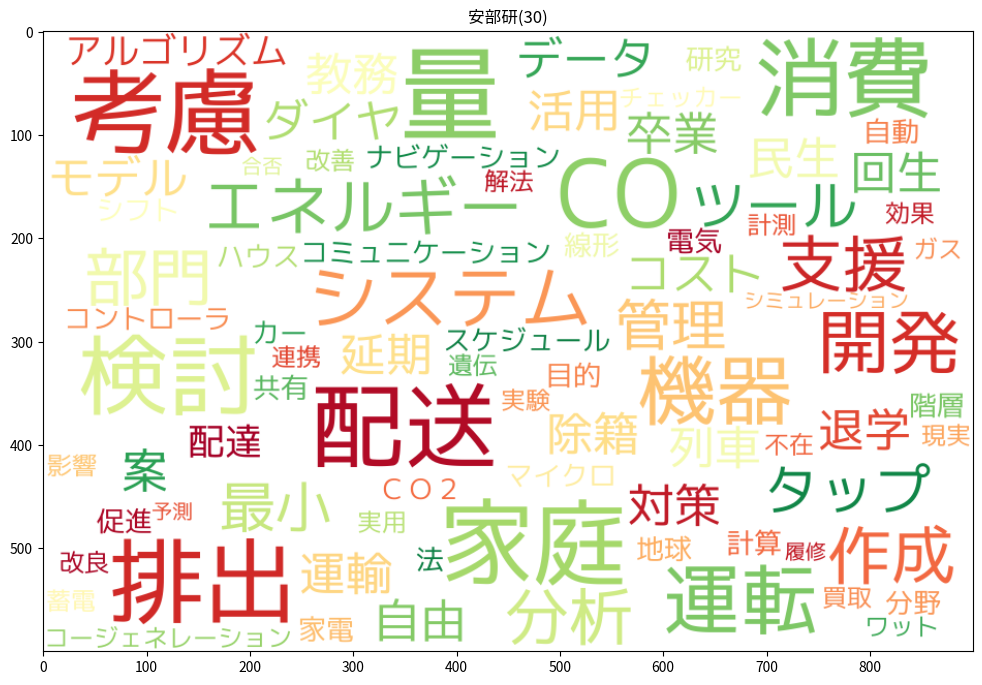

In [22]:
df2 = pd.DataFrame({'text': texts})
npt = nlplot.NLPlot(df2, target_col='text')
# Stopword calculations can be performed.
stopwords = npt.get_stopword(top_n=4, min_freq=0)

fig = plt.figure(figsize=(12, 20))
fig.tight_layout()
fig_wc = npt.wordcloud(
    width = 900,
    height = 600,
    max_words = 100,
    max_font_size = 100,
    colormap = 'RdYlGn', # 'tab20_r',
    stopwords =stopwords,
    mask_file = None,
    save=False
)

# plt.axis('off') 
plt.title(title)
plt.imshow(fig_wc, interpolation="bilinear")      
plt.show()

Cluster No.0: 合志研(43),下川研(15),成研(15),稲永研(10),于研(7)


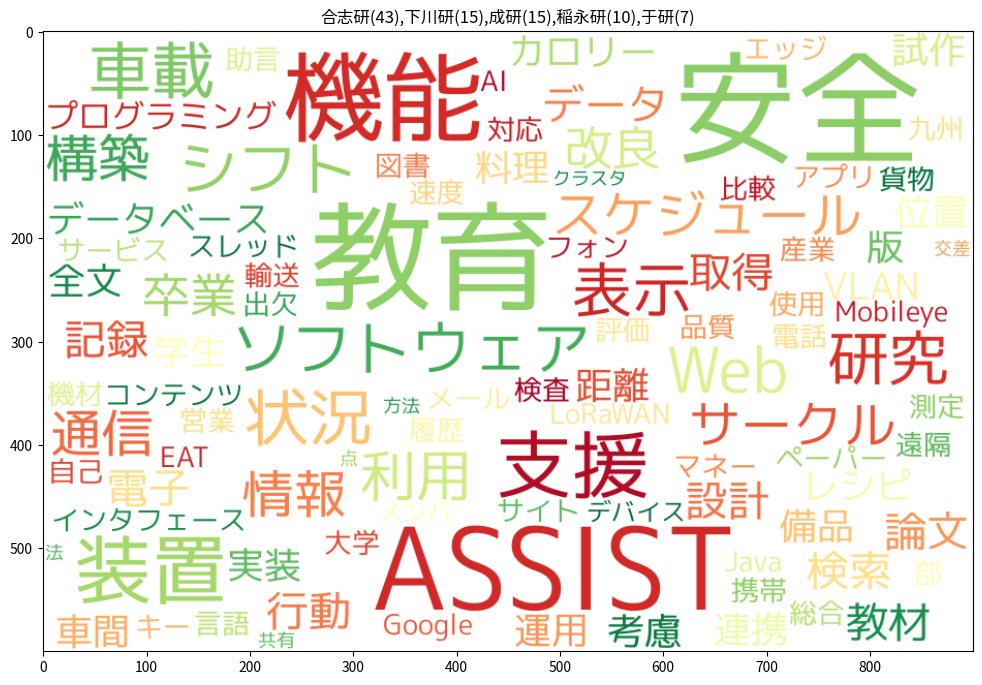

Cluster No.1: 稲永研(42)


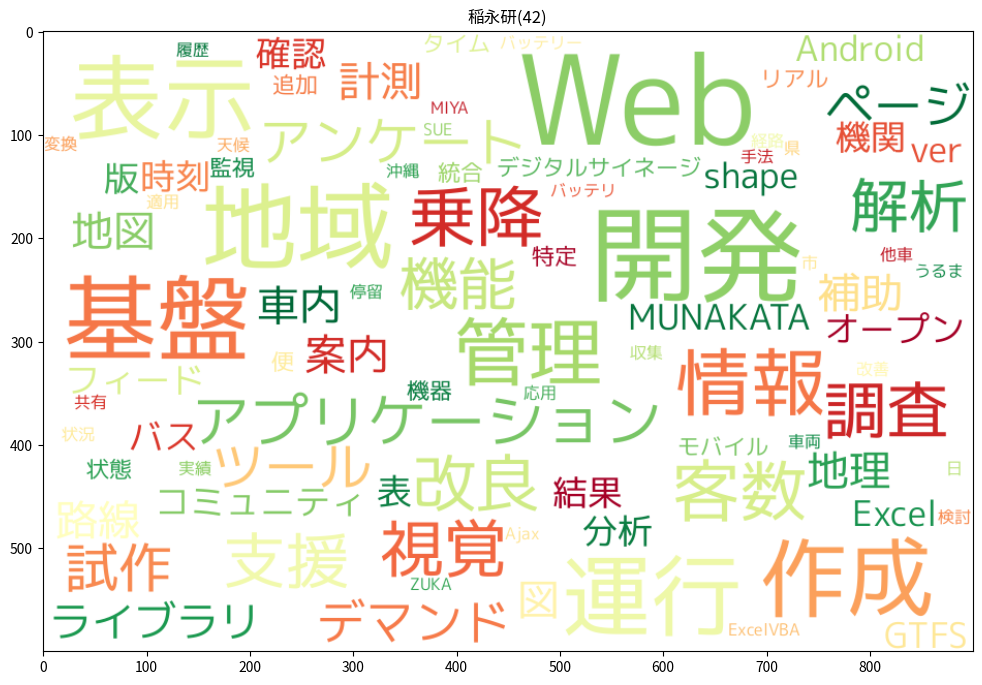

Cluster No.2: 仲研(61),アプドゥハン研(24),稲永研(13),于研(11),朝廣研(10),田中研(10),成研(9)


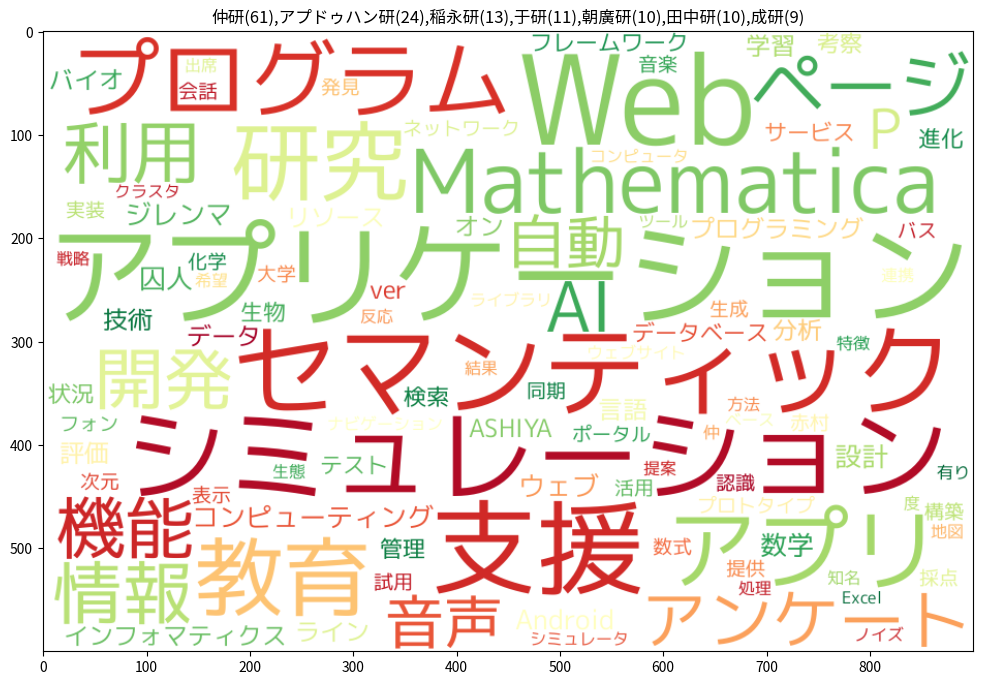

Cluster No.3: 稲永研(26),アプドゥハン研(24),安武研(21),成研(14),田中研(14),下川研(12),澤田研(12),米元研(10),前田研(9)


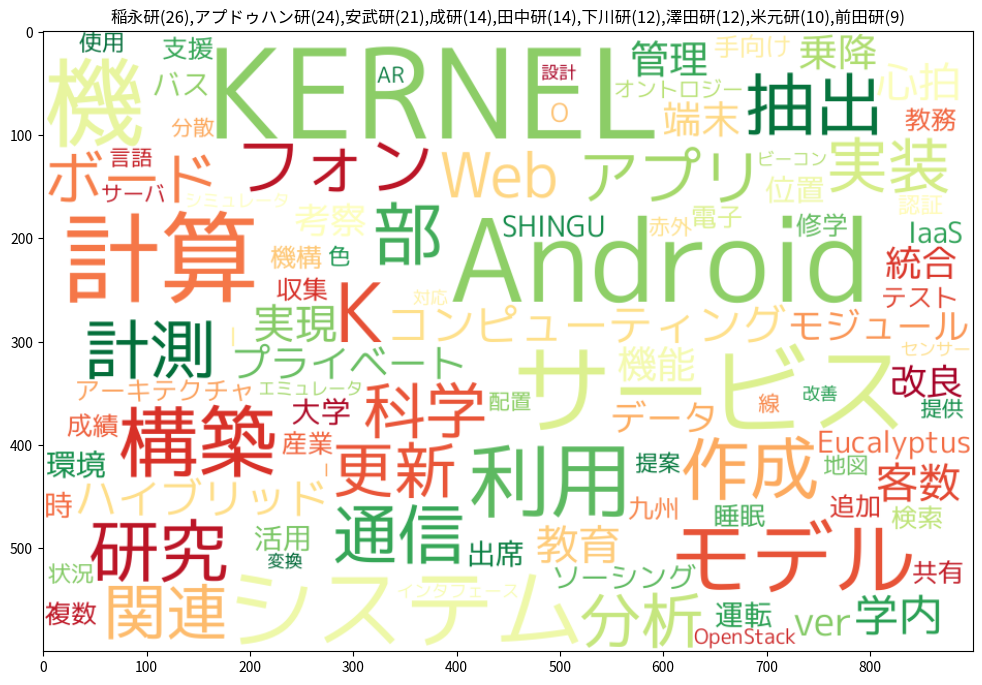

Cluster No.4: 澤田研(54),安部研(18),アプドゥハン研(6),田中研(5)


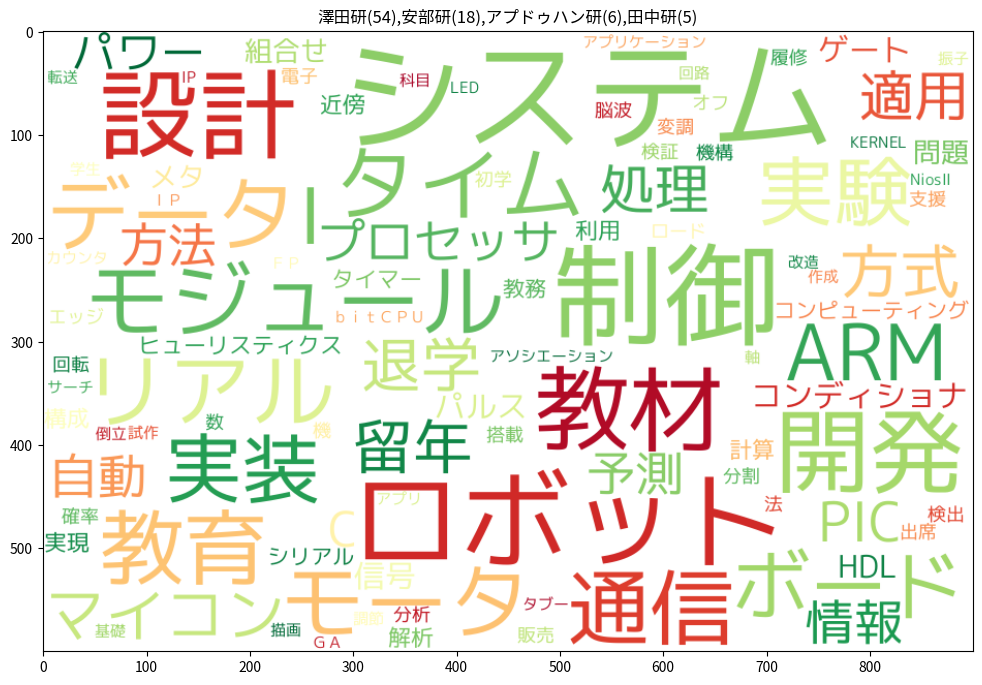

Cluster No.5: 安部研(30)


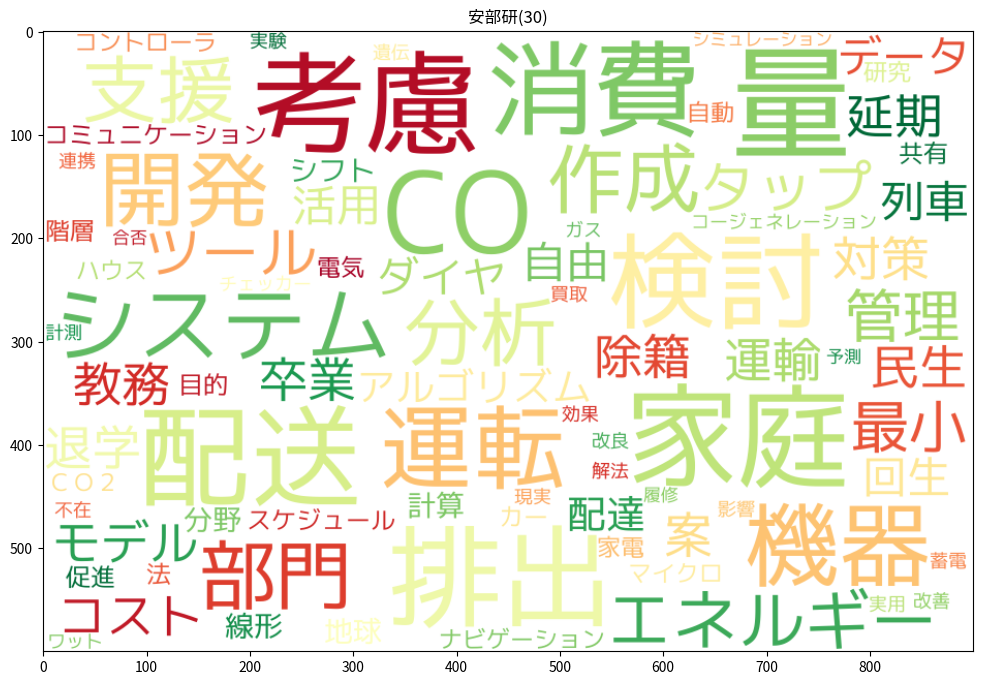

Cluster No.6: 米元研(95),朝廣研(84),安武研(60),仲研(53),田中研(41),石田俊研(36),澤田研(30)


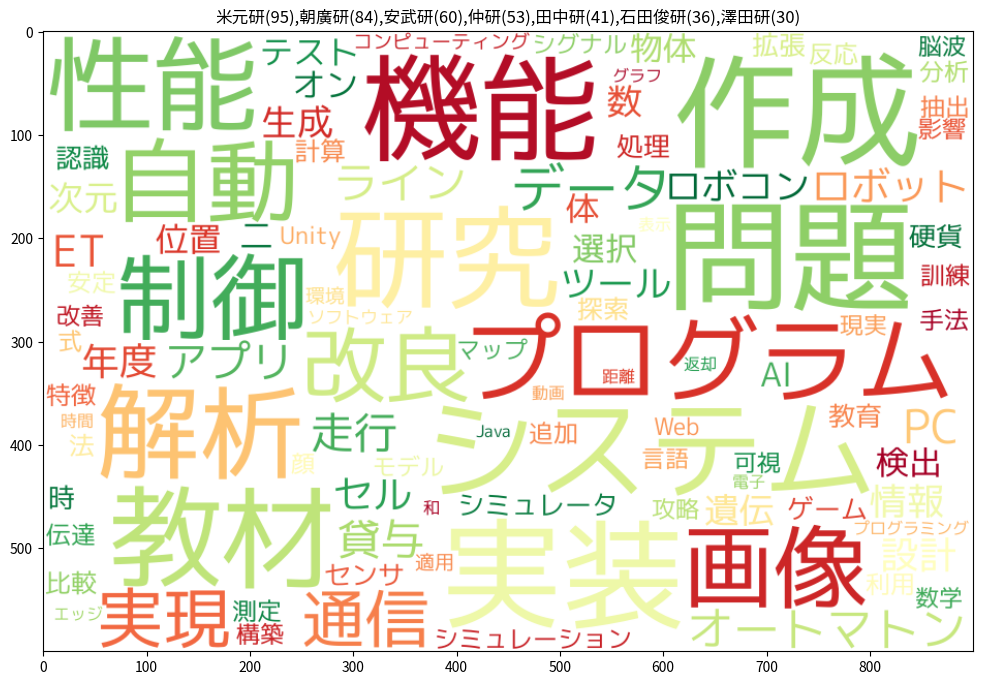

Cluster No.7: 成研(40),安部研(30),仲研(25),米元研(18),下川研(16),安武研(14),朝廣研(10)


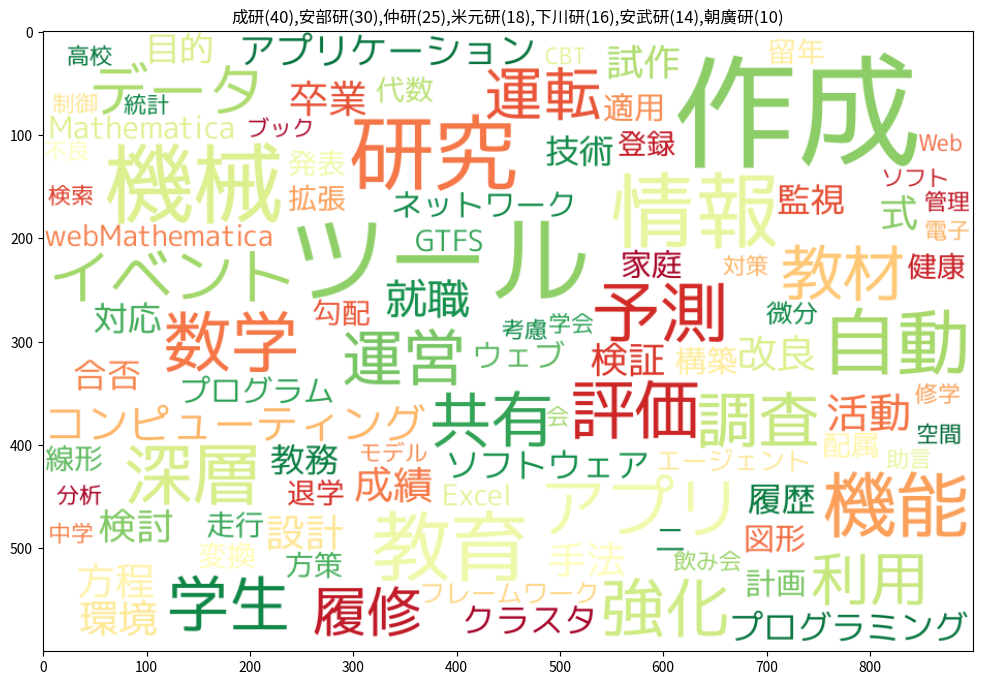

Cluster No.8: 下川研(75),成研(43),稲永研(31),田中研(14),米元研(12),安部研(11)


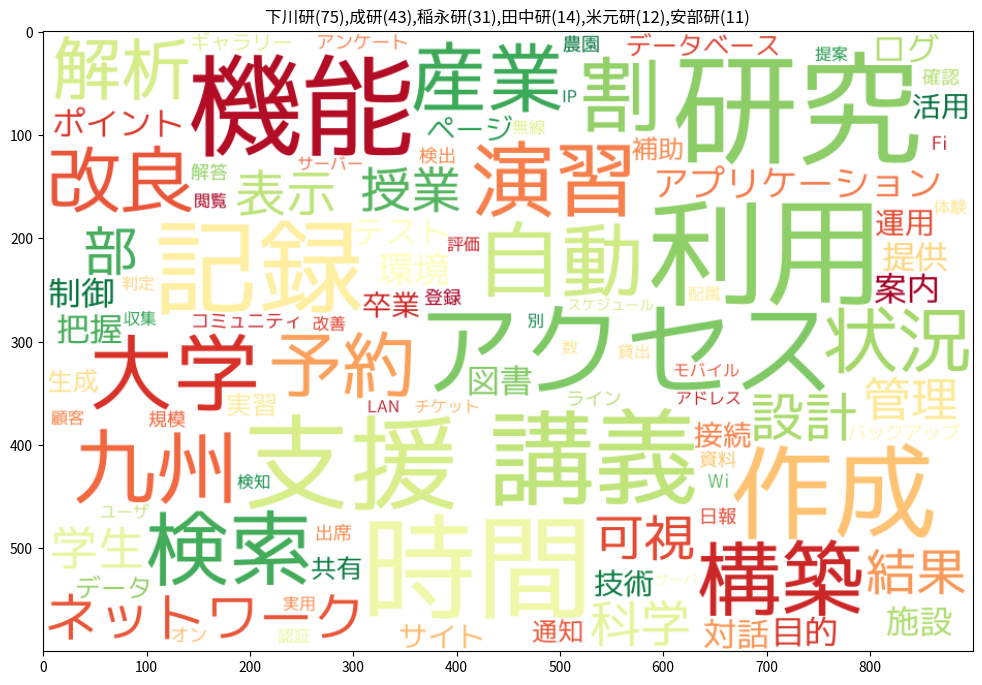

Cluster No.9: 合志研(51),米元研(5)


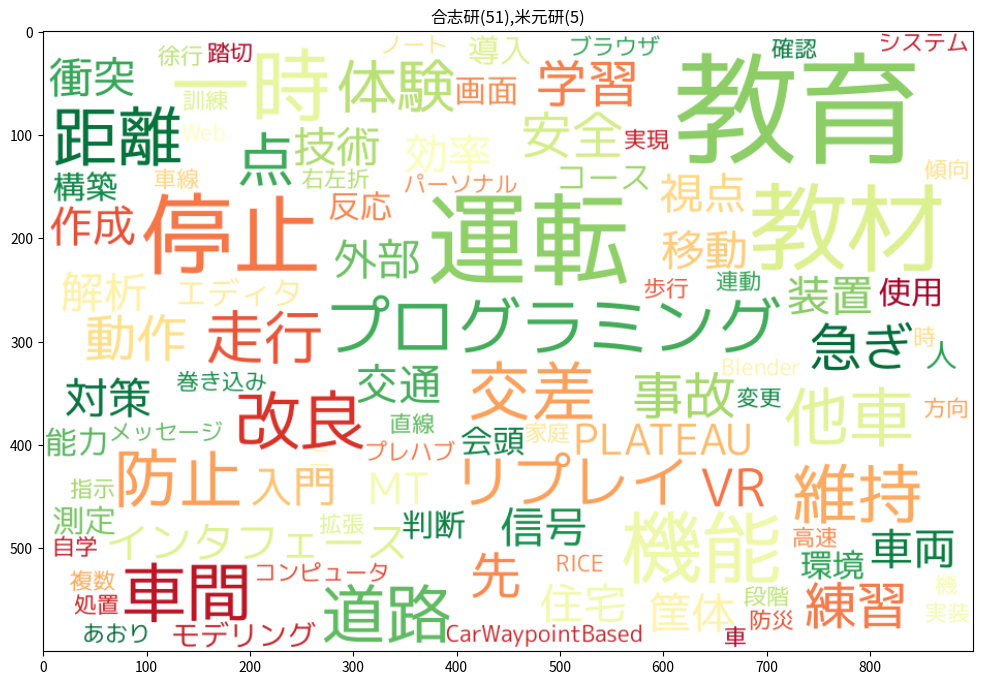

In [24]:
for k in range(n_clust):
    df1 = target_docs_df[target_docs_df['クラスタ']==k]
    vc = df1['研究室'].value_counts()
    n = sum(vc.values)
    title=",".join([f"{k}({c})" for k,c in vc.items() if c>0.05*n])
    print(f"Cluster No.{k}: {title}")
    
    texts =[]
    for text in df1['題目'].values:
        texts += [" ".join(mecab_sep(text))]
    df2 = pd.DataFrame({'text': texts})
    
    npt = nlplot.NLPlot(df2, target_col='text')
    # Stopword calculations can be performed.
    stopwords = npt.get_stopword(top_n=4, min_freq=0)
    
    fig = plt.figure(figsize=(12, 20))
    fig.tight_layout()
    fig_wc = npt.wordcloud(
        width = 900,
        height = 600,
        max_words = 100,
        max_font_size = 120,
        colormap = 'RdYlGn', # 'tab20_r',
        stopwords =stopwords,
        mask_file = None,
        save=False
    )
    
    # plt.axis('off') 
    plt.title(title)
    plt.imshow(fig_wc, interpolation="bilinear")      
    plt.show()